In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [13]:
data = pd.read_csv('AirPassengers.csv', parse_dates = ['Month'], index_col = 'Month')
print(data.head())
print('\n Data Types:')
print(data.dtypes)
data.index

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

 Data Types:
#Passengers    int64
dtype: object


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [21]:
ts = data['#Passengers'].head(10)
ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

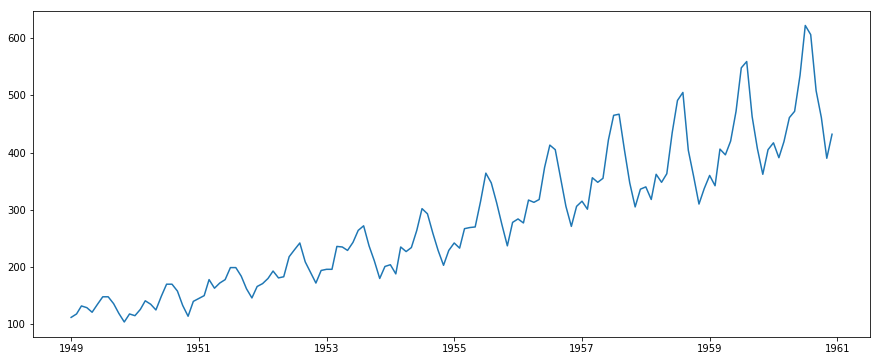

In [46]:
plt.plot(data)
df = data.copy()

In [50]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Determine Rolling Stats
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # Plot rolling Stats
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling std')
    
    plt.legend(loc = 'best')
    plt.title('Rolling Mean vs Std. Dev.')
    plt.show(block = False)    
    
    # Dickey Fuller Test
    print("Dickey Fuller Test")
    dftest = adfuller(timeseries.unstack(),  autolag = 'AIC')
    #print(dftest)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-val', '#Lags Used', 'No. of Obsv.'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s) '%key] = value
    
    print(dfoutput)

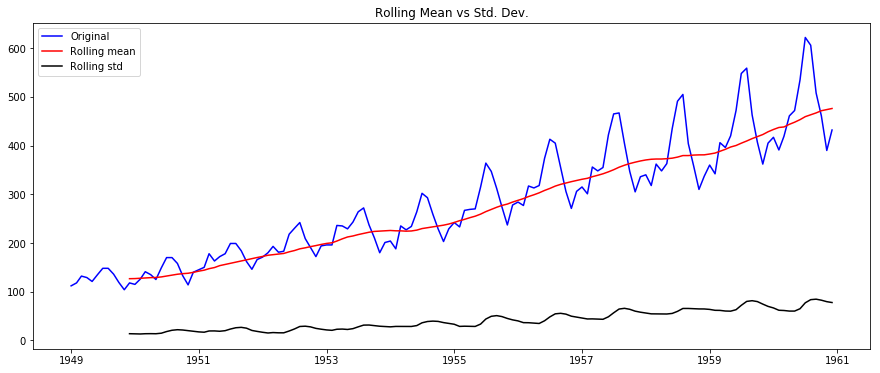

Dickey Fuller Test
Test Statistic             0.815369
p-val                      0.991880
#Lags Used                13.000000
No. of Obsv.             130.000000
Critical Value (1%)       -3.481682
Critical Value (5%)       -2.884042
Critical Value (10%)      -2.578770
dtype: float64


In [51]:
test_stationarity(df)

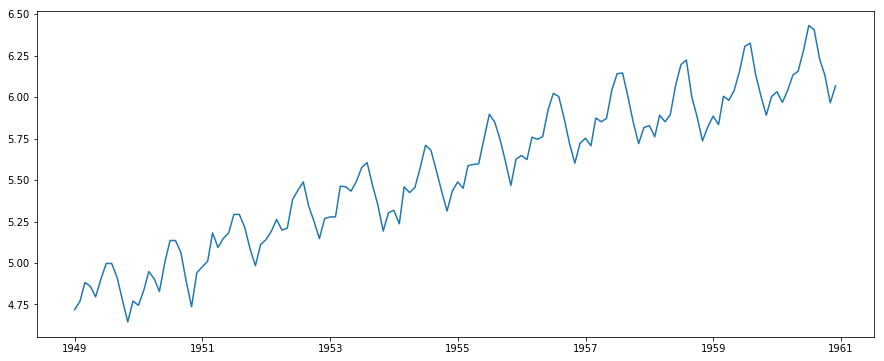

In [74]:
ts_log = np.log(df)
plt.plot(ts_log)

## Estimating & Eliminating Trend
## Smoothing - MA

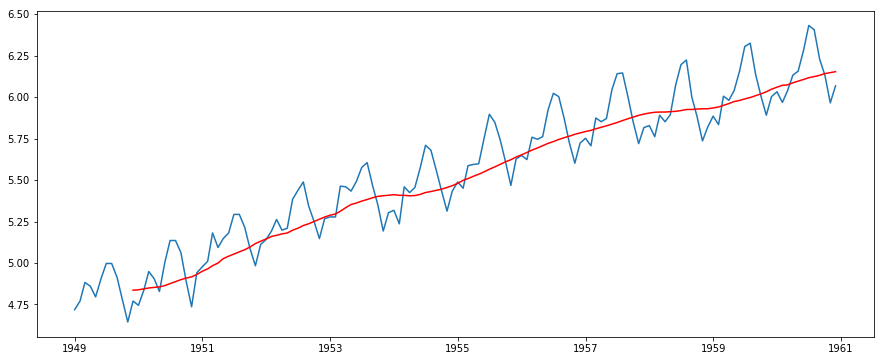

In [57]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color = 'red')

In [61]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


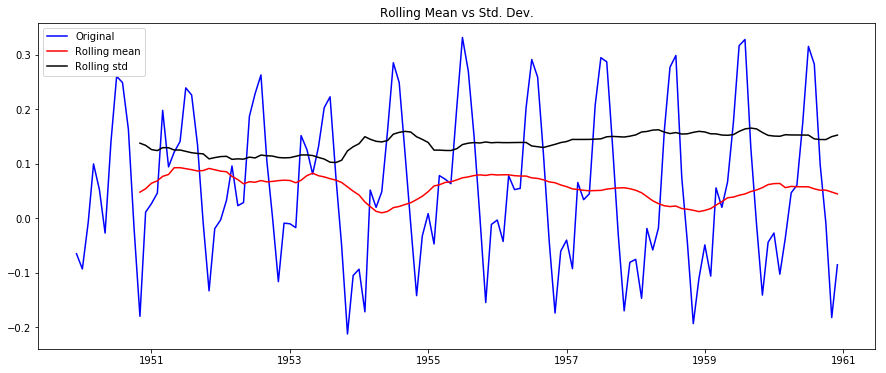

Dickey Fuller Test
Test Statistic            -3.162908
p-val                      0.022235
#Lags Used                13.000000
No. of Obsv.             119.000000
Critical Value (1%)       -3.486535
Critical Value (5%)       -2.886151
Critical Value (10%)      -2.579896
dtype: float64


In [64]:
ts_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(ts_log_moving_avg_diff)

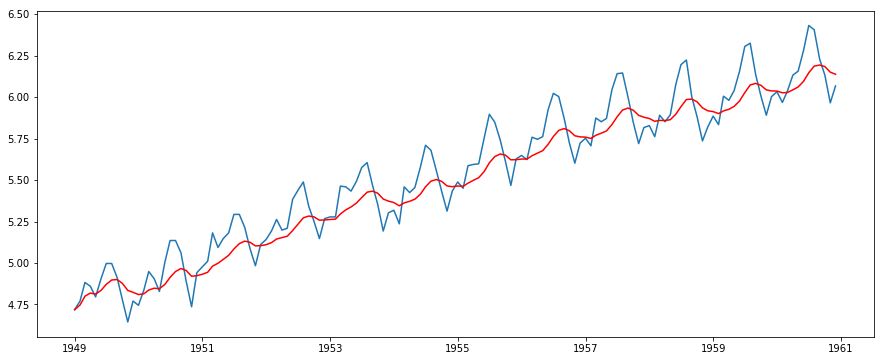

In [76]:
expweighted_avg = ts_log.ewm(span = 12).mean()
plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

## Eliminating Trend & Seasonality
## Differencing

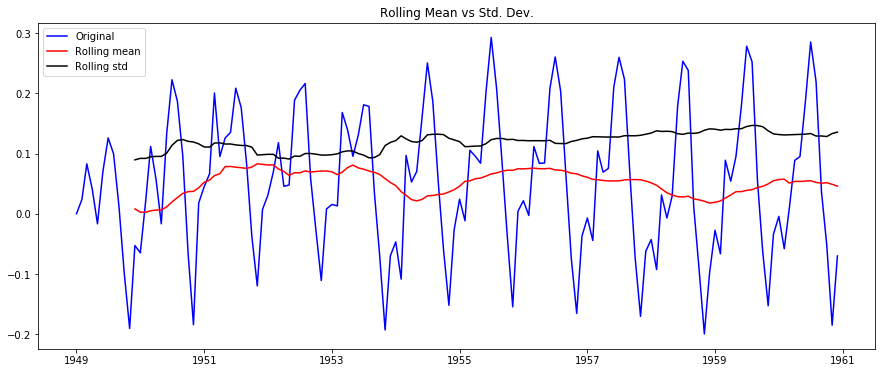

Dickey Fuller Test
Test Statistic            -3.310542
p-val                      0.014414
#Lags Used                13.000000
No. of Obsv.             130.000000
Critical Value (1%)       -3.481682
Critical Value (5%)       -2.884042
Critical Value (10%)      -2.578770
dtype: float64


In [75]:
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity(ts_log_ewma_diff)

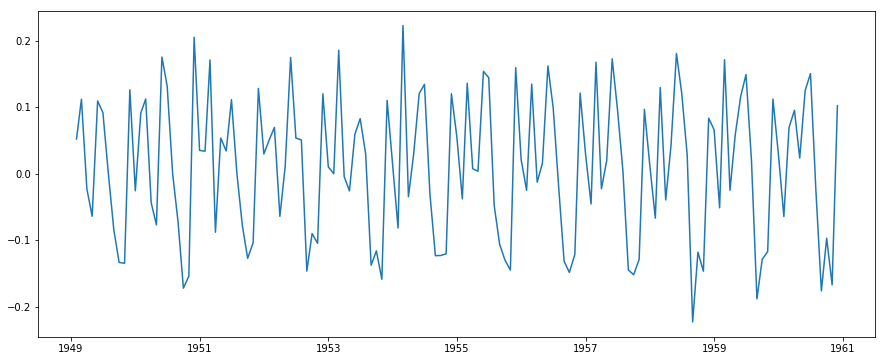

In [71]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

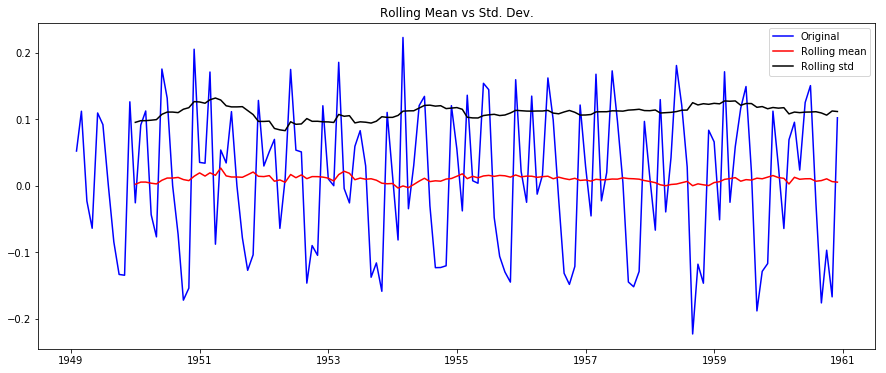

Dickey Fuller Test
Test Statistic            -2.717131
p-val                      0.071121
#Lags Used                14.000000
No. of Obsv.             128.000000
Critical Value (1%)       -3.482501
Critical Value (5%)       -2.884398
Critical Value (10%)      -2.578960
dtype: float64


In [73]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

## Decomposing

#### Both Trend and Seasonality are modeleld separately and the remaining part is the residul which is returned

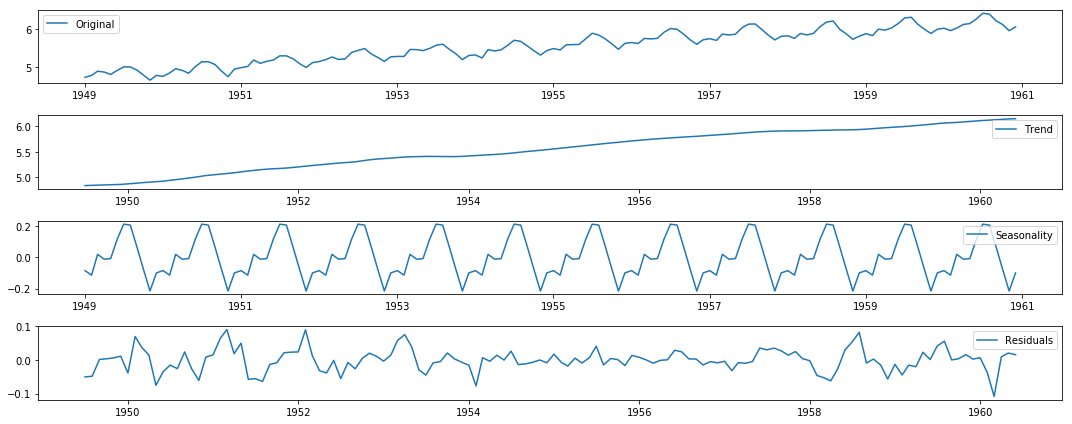

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

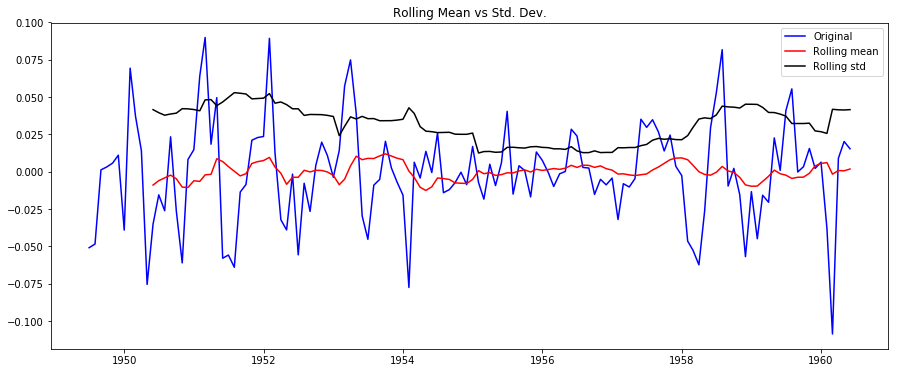

Dickey Fuller Test
Test Statistic          -6.332387e+00
p-val                    2.885059e-08
#Lags Used               9.000000e+00
No. of Obsv.             1.220000e+02
Critical Value (1%)     -3.485122e+00
Critical Value (5%)     -2.885538e+00
Critical Value (10%)    -2.579569e+00
dtype: float64


In [79]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## Forecasting a Time Series

In [81]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags = 20)
lag_pacf = pacf(ts_log_diff, nlags = 20, method = 'ols')

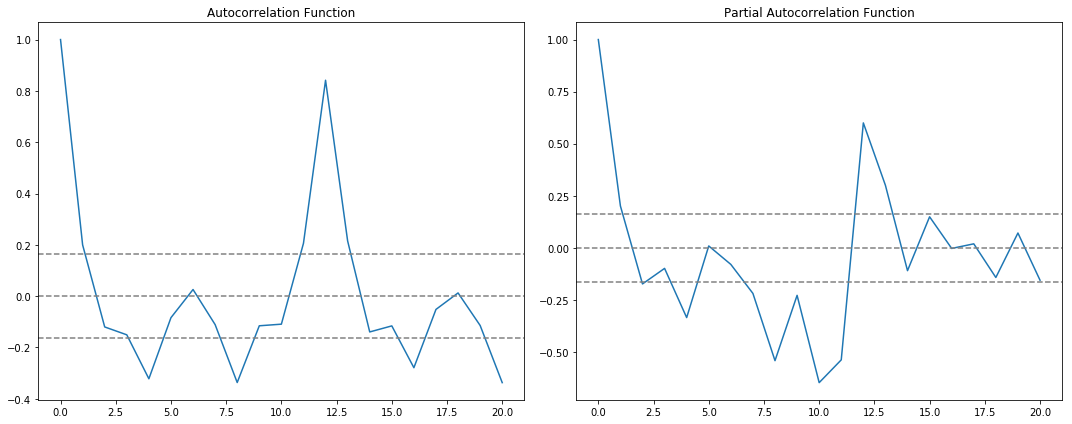

In [83]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [85]:
from statsmodels.tsa.arima_model import ARIMA

## AR Model

C:\Users\GS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\GS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ValueError: Cannot add integral value to Timestamp without freq.

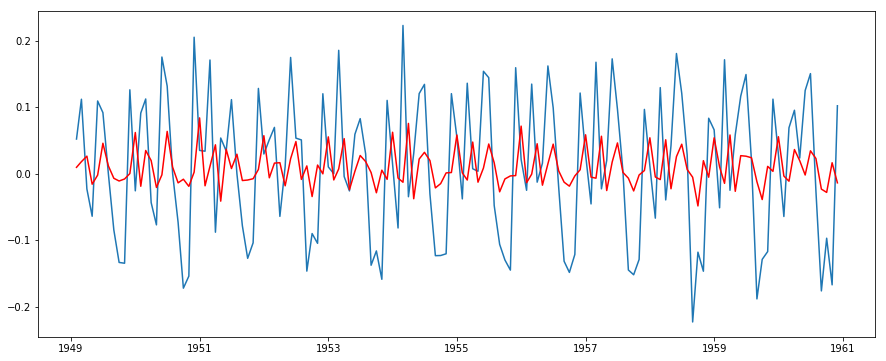

In [86]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

## MA Model

C:\Users\GS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\GS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ValueError: Cannot add integral value to Timestamp without freq.

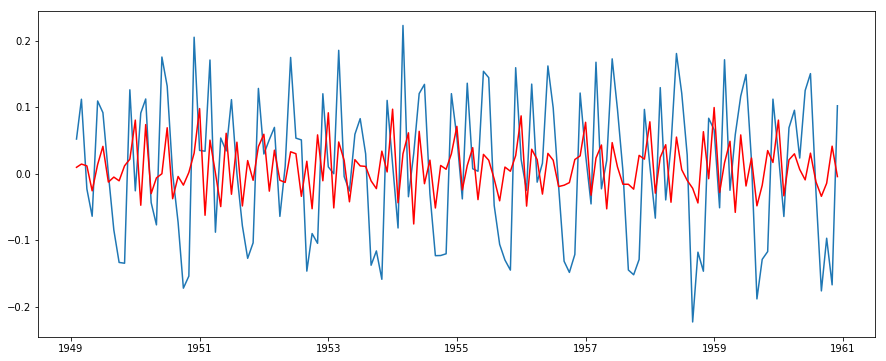

In [87]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

## Combined Model

C:\Users\GS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\GS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ValueError: Cannot add integral value to Timestamp without freq.

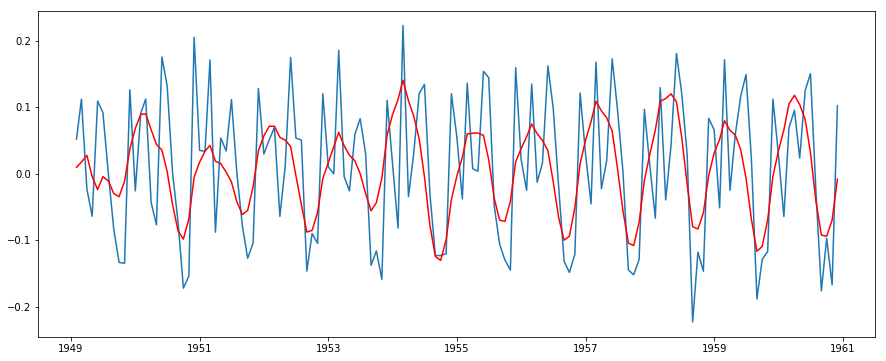

In [88]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [94]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


# DO BELOW AGAIN

In [93]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

SyntaxError: invalid syntax (<ipython-input-93-9fffc44c870e>, line 2)

In [91]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\Users\GS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


NameError: name 'predictions_ARIMA_diff_cumsum' is not defined

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))